In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [1]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Constants
NUM_POINTS = 2048
BATCH_SIZE = 32
LATENT_DIM = 256
EPOCHS = 50
CHECKPOINT_PATH = "pointcloud_autoencoder_checkpoint.pth"
MODEL_PATH = "pointcloud_autoencoder_model.pth"

# Kaggle dataset path
ROOT_DIR = "/kaggle/input/3d-cloudpoint-completion/shapenet"
TRAIN_LIST = os.path.join(ROOT_DIR, "train.list")
VAL_LIST = os.path.join(ROOT_DIR, "val.list")

class PointCloudDataset(Dataset):
    def __init__(self, root_dir, list_file, split='train'):
        self.root_dir = root_dir
        self.split = split
        with open(list_file, 'r') as f:
            self.file_list = [line.strip() for line in f]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        category_id, model_id = file_name.split('/')
        
        partial_path = os.path.join(self.root_dir, self.split, 'partial', category_id, model_id + '.h5')
        gt_path = os.path.join(self.root_dir, self.split, 'gt', category_id, model_id + '.h5')
        
        if not os.path.exists(partial_path) or not os.path.exists(gt_path):
            return self.__getitem__((idx + 1) % len(self.file_list))
        
        with h5py.File(partial_path, 'r') as f:
            partial = np.array(f['data'])
        with h5py.File(gt_path, 'r') as f:
            complete = np.array(f['data'])
        
        partial = (partial - np.mean(partial, axis=0)) / np.max(np.linalg.norm(partial, axis=1))
        complete = (complete - np.mean(complete, axis=0)) / np.max(np.linalg.norm(complete, axis=1))
        
        return torch.tensor(partial, dtype=torch.float32), torch.tensor(complete, dtype=torch.float32)

class PointNetEncoder(nn.Module):
    def __init__(self, point_dim=3, latent_dim=LATENT_DIM):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(point_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, 512, 1)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = x.transpose(1, 2)  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class PointNetDecoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_points=NUM_POINTS, point_dim=3):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, num_points * point_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x).view(-1, NUM_POINTS, 3)
        return x

class PointCloudAutoencoder(nn.Module):
    def __init__(self):
        super(PointCloudAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent), latent

def chamfer_distance(pred, gt):
    pred_nearest = torch.cdist(pred, gt).min(dim=2)[0]
    gt_nearest = torch.cdist(gt, pred).min(dim=2)[0]
    return torch.mean(pred_nearest) + torch.mean(gt_nearest)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointCloudAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load dataset
train_dataset = PointCloudDataset(ROOT_DIR, TRAIN_LIST, 'train')
val_dataset = PointCloudDataset(ROOT_DIR, VAL_LIST, 'val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Load checkpoint if available
start_epoch = 1
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resuming training from epoch {start_epoch}")
else:
    print("🚀 No checkpoint found. Starting training from scratch.")

# Training loop
for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    total_loss = 0

    for partial, complete in tqdm(train_loader, desc=f"Epoch {epoch}"):
        partial, complete = partial.to(device), complete.to(device)

        optimizer.zero_grad()
        reconstructed, _ = model(partial)
        loss = chamfer_distance(reconstructed, complete)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"\n🟢 Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"✅ Checkpoint saved at epoch {epoch}")

# Save final model
torch.save(model.state_dict(), MODEL_PATH)
print("✅ Model saved successfully")


🚀 No checkpoint found. Starting training from scratch.


Epoch 1: 100%|██████████| 906/906 [04:13<00:00,  3.58it/s]



🟢 Epoch 1, Loss: 0.141639
✅ Checkpoint saved at epoch 1


Epoch 2: 100%|██████████| 906/906 [03:55<00:00,  3.85it/s]



🟢 Epoch 2, Loss: 0.113027
✅ Checkpoint saved at epoch 2


Epoch 3: 100%|██████████| 906/906 [04:05<00:00,  3.69it/s]



🟢 Epoch 3, Loss: 0.107396
✅ Checkpoint saved at epoch 3


Epoch 4: 100%|██████████| 906/906 [04:02<00:00,  3.74it/s]



🟢 Epoch 4, Loss: 0.104629
✅ Checkpoint saved at epoch 4


Epoch 5: 100%|██████████| 906/906 [03:40<00:00,  4.11it/s]



🟢 Epoch 5, Loss: 0.102368
✅ Checkpoint saved at epoch 5


Epoch 6: 100%|██████████| 906/906 [03:34<00:00,  4.23it/s]



🟢 Epoch 6, Loss: 0.100778
✅ Checkpoint saved at epoch 6


Epoch 7: 100%|██████████| 906/906 [03:40<00:00,  4.10it/s]



🟢 Epoch 7, Loss: 0.099503
✅ Checkpoint saved at epoch 7


Epoch 8: 100%|██████████| 906/906 [03:48<00:00,  3.97it/s]



🟢 Epoch 8, Loss: 0.098387
✅ Checkpoint saved at epoch 8


Epoch 9: 100%|██████████| 906/906 [03:40<00:00,  4.11it/s]



🟢 Epoch 9, Loss: 0.097239
✅ Checkpoint saved at epoch 9


Epoch 10: 100%|██████████| 906/906 [03:44<00:00,  4.04it/s]



🟢 Epoch 10, Loss: 0.096270
✅ Checkpoint saved at epoch 10


Epoch 11: 100%|██████████| 906/906 [03:43<00:00,  4.05it/s]



🟢 Epoch 11, Loss: 0.095349
✅ Checkpoint saved at epoch 11


Epoch 12: 100%|██████████| 906/906 [03:42<00:00,  4.08it/s]



🟢 Epoch 12, Loss: 0.094868
✅ Checkpoint saved at epoch 12


Epoch 13: 100%|██████████| 906/906 [03:38<00:00,  4.15it/s]



🟢 Epoch 13, Loss: 0.094027
✅ Checkpoint saved at epoch 13


Epoch 14: 100%|██████████| 906/906 [03:33<00:00,  4.24it/s]



🟢 Epoch 14, Loss: 0.093482
✅ Checkpoint saved at epoch 14


Epoch 15: 100%|██████████| 906/906 [03:34<00:00,  4.22it/s]



🟢 Epoch 15, Loss: 0.092937
✅ Checkpoint saved at epoch 15


Epoch 16: 100%|██████████| 906/906 [03:32<00:00,  4.27it/s]



🟢 Epoch 16, Loss: 0.092434
✅ Checkpoint saved at epoch 16


Epoch 17: 100%|██████████| 906/906 [03:30<00:00,  4.31it/s]



🟢 Epoch 17, Loss: 0.092129
✅ Checkpoint saved at epoch 17


Epoch 18: 100%|██████████| 906/906 [03:34<00:00,  4.23it/s]



🟢 Epoch 18, Loss: 0.091656
✅ Checkpoint saved at epoch 18


Epoch 19: 100%|██████████| 906/906 [03:38<00:00,  4.15it/s]



🟢 Epoch 19, Loss: 0.091220
✅ Checkpoint saved at epoch 19


Epoch 20: 100%|██████████| 906/906 [03:37<00:00,  4.17it/s]



🟢 Epoch 20, Loss: 0.091000
✅ Checkpoint saved at epoch 20


Epoch 21: 100%|██████████| 906/906 [03:36<00:00,  4.18it/s]



🟢 Epoch 21, Loss: 0.090901
✅ Checkpoint saved at epoch 21


Epoch 22: 100%|██████████| 906/906 [03:30<00:00,  4.31it/s]



🟢 Epoch 22, Loss: 0.090270
✅ Checkpoint saved at epoch 22


Epoch 23: 100%|██████████| 906/906 [03:33<00:00,  4.24it/s]



🟢 Epoch 23, Loss: 0.089981
✅ Checkpoint saved at epoch 23


Epoch 24: 100%|██████████| 906/906 [03:31<00:00,  4.29it/s]



🟢 Epoch 24, Loss: 0.089850
✅ Checkpoint saved at epoch 24


Epoch 25: 100%|██████████| 906/906 [03:30<00:00,  4.31it/s]



🟢 Epoch 25, Loss: 0.089735
✅ Checkpoint saved at epoch 25


Epoch 26: 100%|██████████| 906/906 [03:33<00:00,  4.24it/s]



🟢 Epoch 26, Loss: 0.089380
✅ Checkpoint saved at epoch 26


Epoch 27: 100%|██████████| 906/906 [03:33<00:00,  4.24it/s]



🟢 Epoch 27, Loss: 0.089054
✅ Checkpoint saved at epoch 27


Epoch 28: 100%|██████████| 906/906 [03:32<00:00,  4.26it/s]



🟢 Epoch 28, Loss: 0.088947
✅ Checkpoint saved at epoch 28


Epoch 29: 100%|██████████| 906/906 [03:34<00:00,  4.23it/s]



🟢 Epoch 29, Loss: 0.088682
✅ Checkpoint saved at epoch 29


Epoch 30: 100%|██████████| 906/906 [03:32<00:00,  4.27it/s]



🟢 Epoch 30, Loss: 0.088475
✅ Checkpoint saved at epoch 30


Epoch 31: 100%|██████████| 906/906 [03:30<00:00,  4.30it/s]



🟢 Epoch 31, Loss: 0.088239
✅ Checkpoint saved at epoch 31


Epoch 32: 100%|██████████| 906/906 [03:25<00:00,  4.41it/s]



🟢 Epoch 32, Loss: 0.088234
✅ Checkpoint saved at epoch 32


Epoch 33: 100%|██████████| 906/906 [03:25<00:00,  4.42it/s]



🟢 Epoch 33, Loss: 0.088058
✅ Checkpoint saved at epoch 33


Epoch 34: 100%|██████████| 906/906 [03:28<00:00,  4.35it/s]



🟢 Epoch 34, Loss: 0.088015
✅ Checkpoint saved at epoch 34


Epoch 35: 100%|██████████| 906/906 [03:26<00:00,  4.39it/s]



🟢 Epoch 35, Loss: 0.087608
✅ Checkpoint saved at epoch 35


Epoch 36: 100%|██████████| 906/906 [03:37<00:00,  4.17it/s]



🟢 Epoch 36, Loss: 0.087532
✅ Checkpoint saved at epoch 36


Epoch 37: 100%|██████████| 906/906 [03:28<00:00,  4.35it/s]



🟢 Epoch 37, Loss: 0.087543
✅ Checkpoint saved at epoch 37


Epoch 38: 100%|██████████| 906/906 [03:36<00:00,  4.18it/s]



🟢 Epoch 38, Loss: 0.087044
✅ Checkpoint saved at epoch 38


Epoch 39: 100%|██████████| 906/906 [03:54<00:00,  3.86it/s]



🟢 Epoch 39, Loss: 0.087175
✅ Checkpoint saved at epoch 39


Epoch 40: 100%|██████████| 906/906 [03:54<00:00,  3.86it/s]



🟢 Epoch 40, Loss: 0.086837
✅ Checkpoint saved at epoch 40


Epoch 41: 100%|██████████| 906/906 [03:56<00:00,  3.84it/s]



🟢 Epoch 41, Loss: 0.086854
✅ Checkpoint saved at epoch 41


Epoch 42: 100%|██████████| 906/906 [03:52<00:00,  3.90it/s]



🟢 Epoch 42, Loss: 0.086546
✅ Checkpoint saved at epoch 42


Epoch 43: 100%|██████████| 906/906 [03:39<00:00,  4.13it/s]



🟢 Epoch 43, Loss: 0.086642
✅ Checkpoint saved at epoch 43


Epoch 44: 100%|██████████| 906/906 [03:43<00:00,  4.05it/s]



🟢 Epoch 44, Loss: 0.086265
✅ Checkpoint saved at epoch 44


Epoch 45: 100%|██████████| 906/906 [03:36<00:00,  4.18it/s]



🟢 Epoch 45, Loss: 0.086316
✅ Checkpoint saved at epoch 45


Epoch 46: 100%|██████████| 906/906 [03:33<00:00,  4.24it/s]



🟢 Epoch 46, Loss: 0.086020
✅ Checkpoint saved at epoch 46


Epoch 47: 100%|██████████| 906/906 [03:35<00:00,  4.21it/s]



🟢 Epoch 47, Loss: 0.086020
✅ Checkpoint saved at epoch 47


Epoch 48: 100%|██████████| 906/906 [03:29<00:00,  4.32it/s]



🟢 Epoch 48, Loss: 0.085754
✅ Checkpoint saved at epoch 48


Epoch 49: 100%|██████████| 906/906 [03:26<00:00,  4.39it/s]



🟢 Epoch 49, Loss: 0.085852
✅ Checkpoint saved at epoch 49


Epoch 50: 100%|██████████| 906/906 [03:27<00:00,  4.37it/s]



🟢 Epoch 50, Loss: 0.085867
✅ Checkpoint saved at epoch 50
✅ Model saved successfully


In [41]:
print(os.listdir("/kaggle/input"))


['ae_pointcompletion', '3d-cloudpoint-completion']


In [42]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Constants (same as in training)
NUM_POINTS = 2048
LATENT_DIM = 256
MODEL_PATH = "pointcloud_autoencoder_model.pth"

# Updated model architecture with batch normalization layers
class PointNetEncoder(nn.Module):
    def __init__(self, point_dim=3, latent_dim=LATENT_DIM):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(point_dim, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, 1)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = x.transpose(1, 2)  
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 512)
        x = F.relu(self.bn5(self.fc1(x)))
        return self.fc2(x)

class PointNetDecoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_points=NUM_POINTS, point_dim=3):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, num_points * point_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x).view(-1, NUM_POINTS, 3)
        return x

class PointCloudAutoencoder(nn.Module):
    def __init__(self):
        super(PointCloudAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent), latent

def chamfer_distance(pred, gt):
    pred_nearest = torch.cdist(pred, gt).min(dim=2)[0]
    gt_nearest = torch.cdist(gt, pred).min(dim=2)[0]
    return torch.mean(pred_nearest) + torch.mean(gt_nearest)

# Dataset class for loading test data
class PointCloudTestDataset(Dataset):
    def __init__(self, root_dir, split='test'):
        self.root_dir = root_dir
        self.split = split
        self.file_list = []
        
        # Path to your test data
        test_dir = os.path.join(root_dir, split, 'partial')
        
        # Get all category directories
        categories = os.listdir(test_dir)
        for category in categories:
            category_path = os.path.join(test_dir, category)
            if os.path.isdir(category_path):
                models = os.listdir(category_path)
                for model in models:
                    if model.endswith('.h5'):
                        self.file_list.append((category, model[:-3]))  # Remove .h5 extension

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        category_id, model_id = self.file_list[idx]
        
        partial_path = os.path.join(self.root_dir, self.split, 'partial', category_id, model_id + '.h5')
        
        with h5py.File(partial_path, 'r') as f:
            partial = np.array(f['data'])
        
        # Normalize the point cloud
        partial = (partial - np.mean(partial, axis=0)) / np.max(np.linalg.norm(partial, axis=1))
        
        return torch.tensor(partial, dtype=torch.float32), f"{category_id}/{model_id}"

# Function to load model and run inference
def load_model_and_predict(model_path, test_data_path, output_path):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model
    model = PointCloudAutoencoder().to(device)
    
    # Load saved model weights
    try:
        # Add weights_only=True to address the FutureWarning
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        print(f"✅ Model loaded successfully from {model_path}")
        model.eval()  # Set to evaluation mode
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # Create test dataset and dataloader
    test_dataset = PointCloudTestDataset(test_data_path)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    print(f"Found {len(test_dataset)} test samples")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Run inference
    with torch.no_grad():
        for partial, file_info in test_loader:
            partial = partial.to(device)
            
            # Get model prediction
            reconstructed, _ = model(partial)
            
            # Convert to numpy for saving
            reconstructed_np = reconstructed.cpu().numpy()[0]
            
            # Get file path information
            category_id, model_id = file_info[0].split('/')
            
            # Create category directory if it doesn't exist
            category_dir = os.path.join(output_path, category_id)
            os.makedirs(category_dir, exist_ok=True)
            
            # Save reconstructed point cloud
            output_file = os.path.join(category_dir, f"{model_id}.h5")
            with h5py.File(output_file, 'w') as f:
                f.create_dataset('data', data=reconstructed_np)
            
            #print(f"Processed and saved: {category_id}/{model_id}")

# Example usage
if __name__ == "__main__":
    # Adjust these paths according to your Kaggle environment
    MODEL_PATH =   "/kaggle/input/ae_pointcompletion/pytorch/default/1/pointcloud_autoencoder.pth"# Path to your uploaded model
    TEST_DATA_PATH = "/kaggle/input/3d-cloudpoint-completion/shapenet"  # Path to test data
    OUTPUT_PATH = "/kaggle/working/predictions"  # Path to save predictions
    
    load_model_and_predict(MODEL_PATH, TEST_DATA_PATH, OUTPUT_PATH)
    print("✅ Inference completed successfully!")

Using device: cuda
✅ Model loaded successfully from /kaggle/input/ae_pointcompletion/pytorch/default/1/pointcloud_autoencoder.pth
Found 1184 test samples
✅ Inference completed successfully!


<ipython-input-50-0c62210119da>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


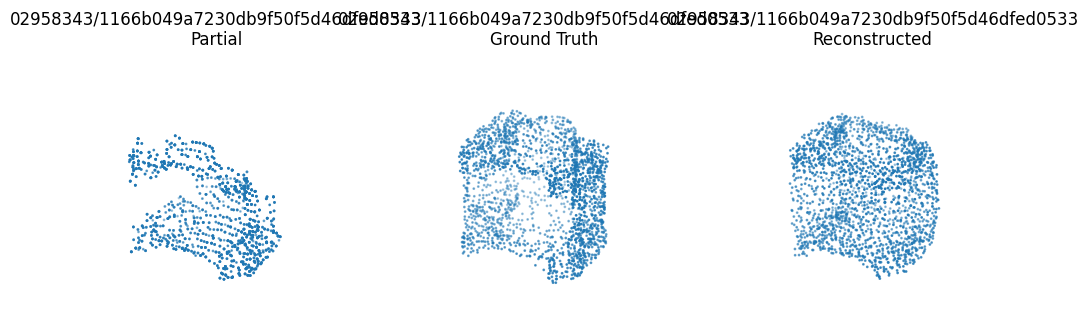

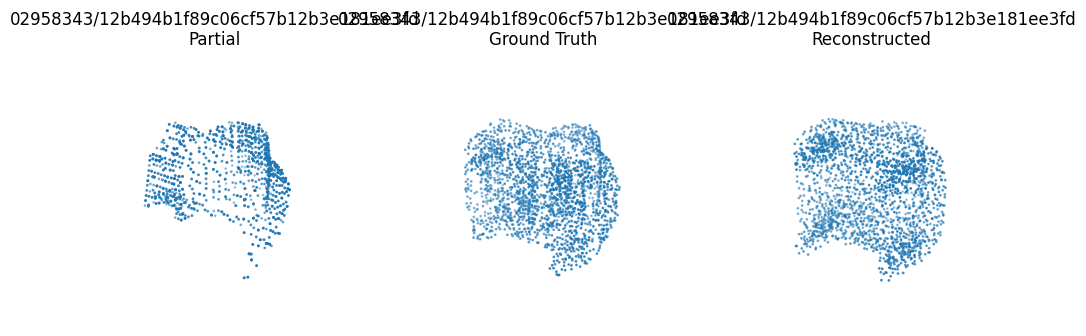

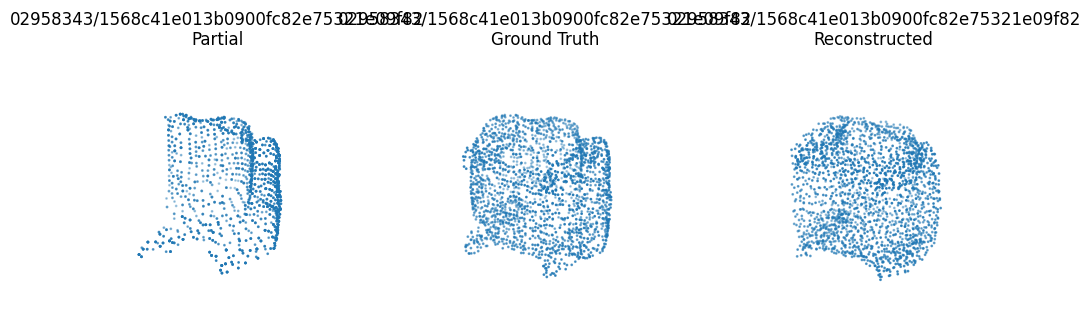

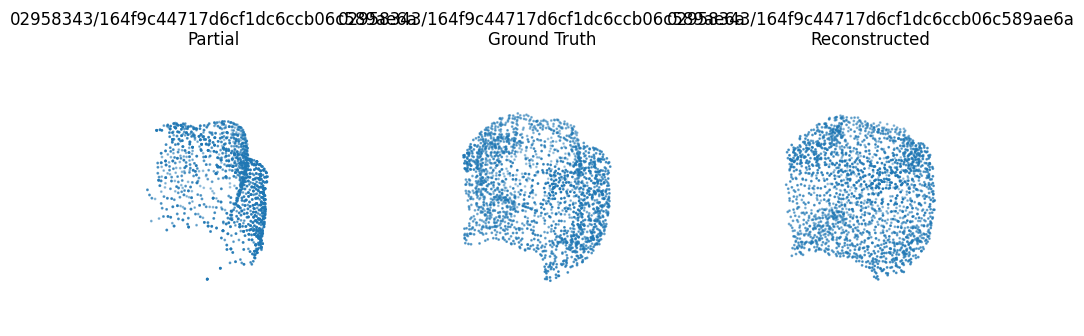

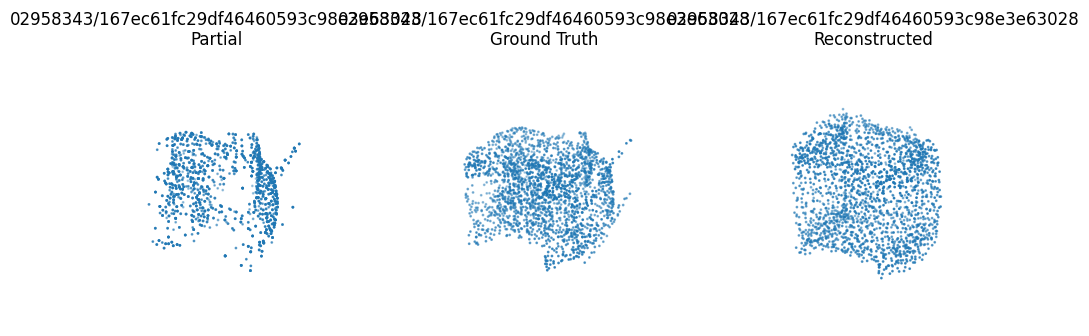

In [50]:
import os
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

# Constants
VAL_DATA_PATH = "/kaggle/input/3d-cloudpoint-completion/shapenet/val"
NUM_SAMPLES = 5  # Number of samples to visualize

def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        return np.array(f['data'])

class PointCloudValDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = []
        
        val_partial_dir = os.path.join(root_dir, 'partial')
        val_gt_dir = os.path.join(root_dir, 'gt')
        
        categories = os.listdir(val_partial_dir)
        for category in categories:
            category_partial_path = os.path.join(val_partial_dir, category)
            category_gt_path = os.path.join(val_gt_dir, category)
            if os.path.isdir(category_partial_path):
                models = sorted(os.listdir(category_partial_path))[:NUM_SAMPLES]
                for model in models:
                    if model.endswith('.h5') and os.path.exists(os.path.join(category_gt_path, model)):
                        self.file_list.append((category, model[:-3]))  # Remove .h5 extension
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        category_id, model_id = self.file_list[idx]
        partial_path = os.path.join(self.root_dir, 'partial', category_id, model_id + '.h5')
        gt_path = os.path.join(self.root_dir, 'gt', category_id, model_id + '.h5')
        
        partial = load_h5_file(partial_path)
        gt = load_h5_file(gt_path)
        
        partial = (partial - np.mean(partial, axis=0)) / np.max(np.linalg.norm(partial, axis=1))
        gt = (gt - np.mean(gt, axis=0)) / np.max(np.linalg.norm(gt, axis=1))
        
        return torch.tensor(partial, dtype=torch.float32), torch.tensor(gt, dtype=torch.float32), f"{category_id}/{model_id}"

# Function to visualize point clouds
def visualize_point_clouds(partial, gt, reconstructed, title):
    fig = plt.figure(figsize=(12, 4))
    
    for i, (cloud, label) in enumerate(zip([partial, gt, reconstructed], ["Partial", "Ground Truth", "Reconstructed"])):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=1)
        ax.set_title(f"{title}\n{label}")
        ax.axis('off')
    
    plt.show()

# Load validation dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointCloudAutoencoder().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

dataset = PointCloudValDataset(VAL_DATA_PATH)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Run inference and visualize
with torch.no_grad():
    for i, (partial, gt, file_info) in enumerate(dataloader):
        if i >= NUM_SAMPLES:
            break
        
        partial = partial.to(device)
        reconstructed, _ = model(partial)
        
        partial_np = partial.cpu().numpy()[0]
        gt_np = gt.numpy()[0]
        reconstructed_np = reconstructed.cpu().numpy()[0]
        
        visualize_point_clouds(partial_np, gt_np, reconstructed_np, file_info[0])
